Nama : Muhammad Fadli Ramadhan

gmail : fadlinisasileader@gmail.com

Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

Selasa, 14 September 2021


In [12]:
# import library
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

# upload dan read dataset
df = pd.read_csv('GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv',
                 encoding='unicode_escape')
df



,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,CÃ´te D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E


In [13]:
# Menghilangkan kolom yang tidak diperlukan
df.drop(['City', 'Latitude', 'Longitude'], axis=1, inplace=True)
display(df)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1849-01-01,26.704,1.435,CÃ´te D'Ivoire
1,1849-02-01,27.434,1.362,CÃ´te D'Ivoire
2,1849-03-01,28.101,1.612,CÃ´te D'Ivoire
3,1849-04-01,26.140,1.387,CÃ´te D'Ivoire
4,1849-05-01,25.427,1.200,CÃ´te D'Ivoire
...,...,...,...,...
239172,2013-05-01,18.979,0.807,China
239173,2013-06-01,23.522,0.647,China
239174,2013-07-01,25.251,1.042,China
239175,2013-08-01,24.528,0.840,China


In [14]:
# meminimalisasi data ke data tahun 1991 - 1999
df['dt'] = pd.to_datetime(df['dt'])
get_data = (df['dt'] > '1991-01-01') & (df['dt'] <= '1999-12-01')
df.loc[get_data]
df = df.loc[get_data]
display(df)


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
1705,1991-02-01,28.353,0.170,CÃ´te D'Ivoire
1706,1991-03-01,28.614,0.385,CÃ´te D'Ivoire
1707,1991-04-01,27.305,0.385,CÃ´te D'Ivoire
1708,1991-05-01,26.855,0.291,CÃ´te D'Ivoire
1709,1991-06-01,26.530,0.265,CÃ´te D'Ivoire
...,...,...,...,...
239007,1999-08-01,24.022,0.360,China
239008,1999-09-01,19.962,0.373,China
239009,1999-10-01,11.949,0.153,China
239010,1999-11-01,5.975,0.119,China


In [15]:
# Mengambil data Negara China saja
df = df.loc[df['Country'].isin(['China'])]
display(df)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
49084,1991-02-01,-10.834,0.356,China
49085,1991-03-01,-3.140,0.297,China
49086,1991-04-01,7.822,0.248,China
49087,1991-05-01,15.888,0.345,China
49088,1991-06-01,20.315,0.304,China
...,...,...,...,...
239007,1999-08-01,24.022,0.360,China
239008,1999-09-01,19.962,0.373,China
239009,1999-10-01,11.949,0.153,China
239010,1999-11-01,5.975,0.119,China


In [16]:
# Cek missing value
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

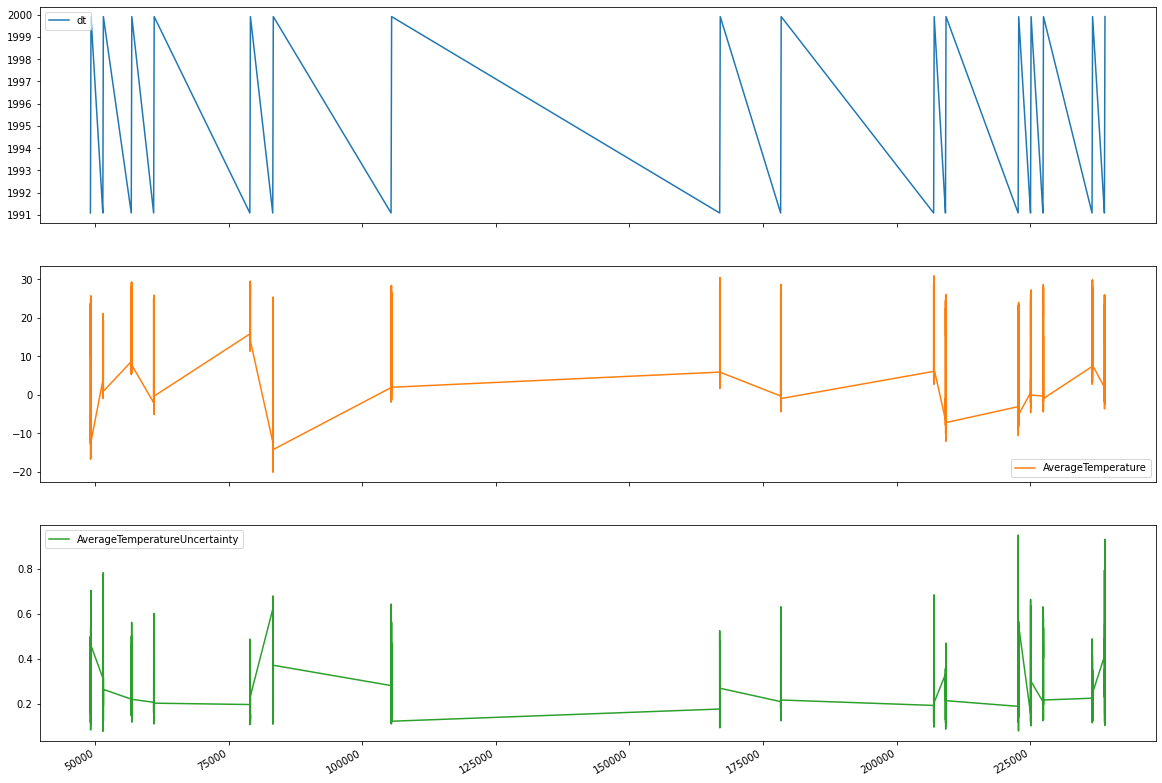

Text(0.5, 0, 'Datetime')

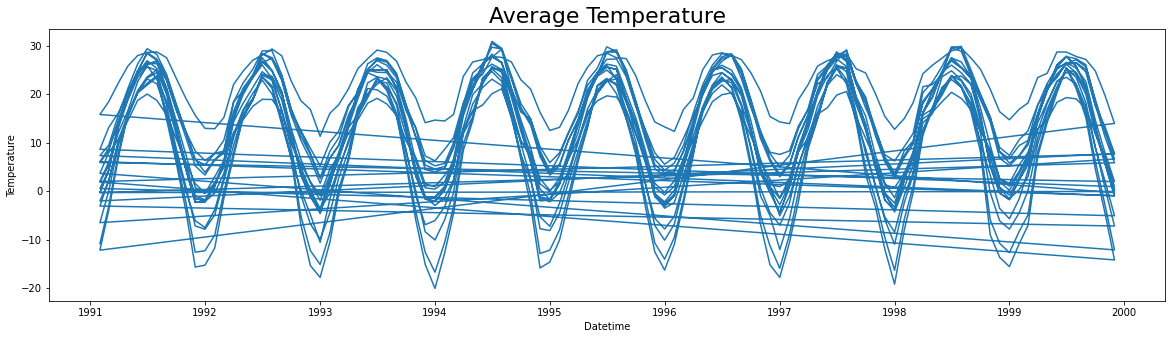

In [20]:
# Membuat plot masing masing kolom dan Average Temperaturepada tiap waktu
df_plot = df
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(20,15))

plt.show()

dates = df['dt'].values
temp = df['AverageTemperature'].values

dates = np.array(dates)
temp = np.array(temp)

plt.figure(figsize=(20,5))
plt.plot(dates, temp)

plt.title('Average Temperature', fontsize=22)
plt.ylabel('Temperature')
plt.xlabel('Datetime')

In [21]:
# split data dengan Validation set sebesar 20% dari total dataset
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, test_size=0.2,
                                                      shuffle = False)
print('Total Data Train : ', len(x_train))
print('Total Data Validation : ', len(x_valid))

Total Data Train :  1369
Total Data Validation :  343


In [23]:
# mengubah data ke dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

# Membuat model Sequential
tf.keras.backend.set_floatx('float64')

train_set = windowed_dataset(x_train, window_size=64, batch_size=200,
                             shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200,
                           shuffle_buffer=1000)

model = Sequential([
        Bidirectional(LSTM(60, return_sequences=True)),
        Bidirectional(LSTM(60)),
        Dense(30, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1)
])

# nilai MAE
mae = (df['AverageTemperature'].max() - df['AverageTemperature'].min()) * 10/100
print (mae)

5.0943


In [25]:
# Fungsi Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < mae and logs.get('val_name') < mae):
      print("\nMAE dari model fit < nilai mae ")
      self.model.stop_training = True
callbacks = myCallback()

# Learning Rate pada Optimizer
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [34]:
#Penggunaan Fungsi Callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< mae and logs.get('val_mae')< mae ):
      print("\nMAE dari model fit < mae ")
      self.model.stop_training = True
callbacks = myCallback()

# Penggunaan Learning Rate pada Optimizer
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, validation_data = val_set,
                    callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
7/7 [==============================] - 14s 1s/step - loss: 7.0269 - mae: 7.5133 - val_loss: 6.6270 - val_mae: 7.1132
Epoch 2/100
7/7 [==============================] - 7s 948ms/step - loss: 7.0124 - mae: 7.5000 - val_loss: 6.6195 - val_mae: 7.1052
Epoch 3/100
7/7 [==============================] - 7s 954ms/step - loss: 6.9951 - mae: 7.4829 - val_loss: 6.5890 - val_mae: 7.0747
Epoch 4/100
7/7 [==============================] - 7s 955ms/step - loss: 6.9718 - mae: 7.4586 - val_loss: 6.5599 - val_mae: 7.0469
Epoch 5/100
7/7 [==============================] - 7s 958ms/step - loss: 6.9509 - mae: 7.4388 - val_loss: 6.5456 - val_mae: 7.0312
Epoch 6/100
7/7 [==============================] - 7s 954ms/step - loss: 6.9209 - mae: 7.4081 - val_loss: 6.5026 - val_mae: 6.9882
Epoch 7/100
7/7 [==============================] - 7s 964ms/step - loss: 6.8889 - mae: 7.3759 - val_loss: 6.4681 - val_mae: 6.9535
Epoch 8/100
7/7 [==============================] - 7s 957ms/step - loss: 6.8529 - mae

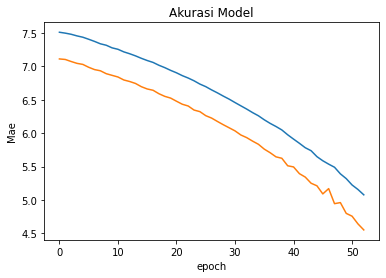

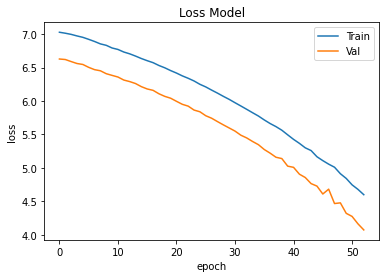

In [35]:
# Plot akurasi dan loss model

# Plot akurasi
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()